In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : False,
    'huntington'    : True,
    'left'          : True,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'normalized','im':'t1','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : ['TFC','UHDRSmotor','Digit_symbol_correct','stroop_word'],
    'outp'          : 'diffusion_fa',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_MSE_7_0_0_0_0_0_t1t2_normalized_e_TFC_UHDRSmotor_Digit_symbol_correct_stroop_word_e_1_1_e_1_0_diffusion_fa_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_1_42_n_normalized_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(663976, 832)
(663976, 1)
validation
(128936, 832)
(128936, 1)
test
(61376, 832)
(61376, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 832)]             0         


 dense (Dense)               (None, 1024)              852992    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 1542145 (5.88 MB)


Trainable params: 1542145 (5.88 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/67 [..............................] - ETA: 1:25 - loss: 0.1690 - STD: 1.5000e-04 - MAE: 0.3972

 4/67 [>.............................] - ETA: 1s - loss: 0.0590 - STD: 3.6021e-04 - MAE: 0.1885  

 8/67 [==>...........................] - ETA: 0s - loss: 0.0436 - STD: 2.3634e-04 - MAE: 0.1604

11/67 [===>..........................] - ETA: 3s - loss: 0.0409 - STD: 1.7787e-04 - MAE: 0.1561

14/67 [=====>........................] - ETA: 2s - loss: 0.0383 - STD: 1.4332e-04 - MAE: 0.1517

17/67 [======>.......................] - ETA: 2s - loss: 0.0354 - STD: 1.2318e-04 - MAE: 0.1447

20/67 [=======>......................] - ETA: 2s - loss: 0.0322 - STD: 1.1012e-04 - MAE: 0.1362

23/67 [=========>....................] - ETA: 1s - loss: 0.0295 - STD: 1.0011e-04 - MAE: 0.1296

26/67 [==========>...................] - ETA: 1s - loss: 0.0276 - STD: 9.1605e-05 - MAE: 0.1262

29/67 [===========>..................] - ETA: 1s - loss: 0.0263 - STD: 8.4012e-05 - MAE: 0.1239

32/67 [=============>................] - ETA: 1s - loss: 0.0250 - STD: 7.7804e-05 - MAE: 0.1210

35/67 [==============>...............] - ETA: 1s - loss: 0.0238 - STD: 7.2890e-05 - MAE: 0.1178

38/67 [================>.............] - ETA: 0s - loss: 0.0228 - STD: 6.8942e-05 - MAE: 0.1150

41/67 [=================>............] - ETA: 0s - loss: 0.0221 - STD: 6.5736e-05 - MAE: 0.1126

44/67 [==================>...........] - ETA: 0s - loss: 0.0214 - STD: 6.3029e-05 - MAE: 0.1105

47/67 [====================>.........] - ETA: 0s - loss: 0.0207 - STD: 6.0686e-05 - MAE: 0.1088

50/67 [=====================>........] - ETA: 0s - loss: 0.0202 - STD: 5.8752e-05 - MAE: 0.1074

53/67 [======================>.......] - ETA: 0s - loss: 0.0197 - STD: 5.7160e-05 - MAE: 0.1063

56/67 [========================>.....] - ETA: 0s - loss: 0.0192 - STD: 5.5770e-05 - MAE: 0.1052

59/67 [=========================>....] - ETA: 0s - loss: 0.0188 - STD: 5.4592e-05 - MAE: 0.1042

62/67 [==========================>...] - ETA: 0s - loss: 0.0185 - STD: 5.3677e-05 - MAE: 0.1031

65/67 [============================>.] - ETA: 0s - loss: 0.0182 - STD: 5.2976e-05 - MAE: 0.1022

67/67 [==============================] - 4s 36ms/step - loss: 0.0179 - STD: 5.2566e-05 - MAE: 0.1016 - val_loss: 0.0103 - val_STD: 3.0266e-05 - val_MAE: 0.0801


Epoch 2/10000


 1/67 [..............................] - ETA: 3s - loss: 0.0111 - STD: 4.0627e-05 - MAE: 0.0819

 4/67 [>.............................] - ETA: 1s - loss: 0.0114 - STD: 4.1326e-05 - MAE: 0.0835

 8/67 [==>...........................] - ETA: 1s - loss: 0.0114 - STD: 4.2586e-05 - MAE: 0.0840

11/67 [===>..........................] - ETA: 1s - loss: 0.0114 - STD: 4.3757e-05 - MAE: 0.0843

14/67 [=====>........................] - ETA: 0s - loss: 0.0114 - STD: 4.5027e-05 - MAE: 0.0844

17/67 [======>.......................] - ETA: 0s - loss: 0.0115 - STD: 4.6467e-05 - MAE: 0.0843

20/67 [=======>......................] - ETA: 0s - loss: 0.0114 - STD: 4.7912e-05 - MAE: 0.0841

23/67 [=========>....................] - ETA: 0s - loss: 0.0114 - STD: 4.9455e-05 - MAE: 0.0841

26/67 [==========>...................] - ETA: 0s - loss: 0.0115 - STD: 5.1048e-05 - MAE: 0.0842

29/67 [===========>..................] - ETA: 0s - loss: 0.0114 - STD: 5.2893e-05 - MAE: 0.0841

32/67 [=============>................] - ETA: 0s - loss: 0.0114 - STD: 5.4746e-05 - MAE: 0.0841

35/67 [==============>...............] - ETA: 0s - loss: 0.0114 - STD: 5.6632e-05 - MAE: 0.0841

38/67 [================>.............] - ETA: 0s - loss: 0.0114 - STD: 5.8578e-05 - MAE: 0.0841

41/67 [=================>............] - ETA: 0s - loss: 0.0114 - STD: 6.0545e-05 - MAE: 0.0841

44/67 [==================>...........] - ETA: 0s - loss: 0.0114 - STD: 6.2644e-05 - MAE: 0.0841

47/67 [====================>.........] - ETA: 0s - loss: 0.0114 - STD: 6.4961e-05 - MAE: 0.0840

50/67 [=====================>........] - ETA: 0s - loss: 0.0114 - STD: 6.7463e-05 - MAE: 0.0840

54/67 [=======================>......] - ETA: 0s - loss: 0.0114 - STD: 7.1082e-05 - MAE: 0.0840

57/67 [========================>.....] - ETA: 0s - loss: 0.0114 - STD: 7.3967e-05 - MAE: 0.0840

60/67 [=========================>....] - ETA: 0s - loss: 0.0114 - STD: 7.7143e-05 - MAE: 0.0841

63/67 [===========================>..] - ETA: 0s - loss: 0.0114 - STD: 8.0547e-05 - MAE: 0.0841

67/67 [==============================] - ETA: 0s - loss: 0.0114 - STD: 8.5489e-05 - MAE: 0.0841

67/67 [==============================] - 1s 21ms/step - loss: 0.0114 - STD: 8.5489e-05 - MAE: 0.0841 - val_loss: 0.0103 - val_STD: 1.3189e-04 - val_MAE: 0.0810


Epoch 3/10000


 1/67 [..............................] - ETA: 3s - loss: 0.0115 - STD: 1.7683e-04 - MAE: 0.0843

 4/67 [>.............................] - ETA: 1s - loss: 0.0116 - STD: 1.8516e-04 - MAE: 0.0844

 7/67 [==>...........................] - ETA: 1s - loss: 0.0116 - STD: 1.9471e-04 - MAE: 0.0846

10/67 [===>..........................] - ETA: 1s - loss: 0.0115 - STD: 2.0533e-04 - MAE: 0.0846

13/67 [====>.........................] - ETA: 1s - loss: 0.0115 - STD: 2.1664e-04 - MAE: 0.0845

17/67 [======>.......................] - ETA: 0s - loss: 0.0115 - STD: 2.3313e-04 - MAE: 0.0845

20/67 [=======>......................] - ETA: 0s - loss: 0.0115 - STD: 2.4691e-04 - MAE: 0.0844

23/67 [=========>....................] - ETA: 0s - loss: 0.0115 - STD: 2.6200e-04 - MAE: 0.0843

26/67 [==========>...................] - ETA: 0s - loss: 0.0115 - STD: 2.7889e-04 - MAE: 0.0842

29/67 [===========>..................] - ETA: 0s - loss: 0.0115 - STD: 2.9750e-04 - MAE: 0.0842

32/67 [=============>................] - ETA: 0s - loss: 0.0115 - STD: 3.1827e-04 - MAE: 0.0842

35/67 [==============>...............] - ETA: 0s - loss: 0.0114 - STD: 3.4090e-04 - MAE: 0.0841

38/67 [================>.............] - ETA: 0s - loss: 0.0114 - STD: 3.6687e-04 - MAE: 0.0841

41/67 [=================>............] - ETA: 0s - loss: 0.0114 - STD: 3.9617e-04 - MAE: 0.0841

44/67 [==================>...........] - ETA: 0s - loss: 0.0114 - STD: 4.2918e-04 - MAE: 0.0840

48/67 [====================>.........] - ETA: 0s - loss: 0.0114 - STD: 4.8019e-04 - MAE: 0.0840

51/67 [=====================>........] - ETA: 0s - loss: 0.0114 - STD: 5.2444e-04 - MAE: 0.0840

55/67 [=======================>......] - ETA: 0s - loss: 0.0114 - STD: 5.9373e-04 - MAE: 0.0839

58/67 [========================>.....] - ETA: 0s - loss: 0.0114 - STD: 6.5384e-04 - MAE: 0.0839

61/67 [==========================>...] - ETA: 0s - loss: 0.0114 - STD: 7.2255e-04 - MAE: 0.0839

64/67 [===========================>..] - ETA: 0s - loss: 0.0114 - STD: 8.0237e-04 - MAE: 0.0838

67/67 [==============================] - 1s 21ms/step - loss: 0.0114 - STD: 8.9370e-04 - MAE: 0.0838 - val_loss: 0.0100 - val_STD: 0.0024 - val_MAE: 0.0800


Epoch 4/10000


 1/67 [..............................] - ETA: 2s - loss: 0.0111 - STD: 0.0031 - MAE: 0.0827

 4/67 [>.............................] - ETA: 1s - loss: 0.0110 - STD: 0.0034 - MAE: 0.0826

 7/67 [==>...........................] - ETA: 1s - loss: 0.0111 - STD: 0.0038 - MAE: 0.0831

10/67 [===>..........................] - ETA: 1s - loss: 0.0111 - STD: 0.0041 - MAE: 0.0831

13/67 [====>.........................] - ETA: 1s - loss: 0.0111 - STD: 0.0045 - MAE: 0.0830

16/67 [======>.......................] - ETA: 0s - loss: 0.0110 - STD: 0.0050 - MAE: 0.0827

19/67 [=======>......................] - ETA: 0s - loss: 0.0109 - STD: 0.0054 - MAE: 0.0825

22/67 [========>.....................] - ETA: 0s - loss: 0.0109 - STD: 0.0060 - MAE: 0.0823

25/67 [==========>...................] - ETA: 0s - loss: 0.0108 - STD: 0.0066 - MAE: 0.0821

28/67 [===========>..................] - ETA: 0s - loss: 0.0108 - STD: 0.0073 - MAE: 0.0819

31/67 [============>.................] - ETA: 0s - loss: 0.0107 - STD: 0.0080 - MAE: 0.0818

34/67 [==============>...............] - ETA: 0s - loss: 0.0107 - STD: 0.0089 - MAE: 0.0816

38/67 [================>.............] - ETA: 0s - loss: 0.0106 - STD: 0.0101 - MAE: 0.0814

41/67 [=================>............] - ETA: 0s - loss: 0.0106 - STD: 0.0111 - MAE: 0.0812

44/67 [==================>...........] - ETA: 0s - loss: 0.0105 - STD: 0.0121 - MAE: 0.0810

47/67 [====================>.........] - ETA: 0s - loss: 0.0104 - STD: 0.0133 - MAE: 0.0807

50/67 [=====================>........] - ETA: 0s - loss: 0.0104 - STD: 0.0144 - MAE: 0.0804

54/67 [=======================>......] - ETA: 0s - loss: 0.0103 - STD: 0.0160 - MAE: 0.0801

58/67 [========================>.....] - ETA: 0s - loss: 0.0102 - STD: 0.0176 - MAE: 0.0798

61/67 [==========================>...] - ETA: 0s - loss: 0.0101 - STD: 0.0188 - MAE: 0.0795

64/67 [===========================>..] - ETA: 0s - loss: 0.0101 - STD: 0.0199 - MAE: 0.0793

67/67 [==============================] - 1s 21ms/step - loss: 0.0100 - STD: 0.0210 - MAE: 0.0791 - val_loss: 0.0077 - val_STD: 0.0337 - val_MAE: 0.0695


Epoch 5/10000


 1/67 [..............................] - ETA: 3s - loss: 0.0089 - STD: 0.0442 - MAE: 0.0746

 4/67 [>.............................] - ETA: 1s - loss: 0.0087 - STD: 0.0439 - MAE: 0.0738

 7/67 [==>...........................] - ETA: 1s - loss: 0.0087 - STD: 0.0435 - MAE: 0.0735

10/67 [===>..........................] - ETA: 1s - loss: 0.0086 - STD: 0.0434 - MAE: 0.0733

13/67 [====>.........................] - ETA: 1s - loss: 0.0086 - STD: 0.0433 - MAE: 0.0730

16/67 [======>.......................] - ETA: 0s - loss: 0.0085 - STD: 0.0437 - MAE: 0.0729

19/67 [=======>......................] - ETA: 0s - loss: 0.0085 - STD: 0.0440 - MAE: 0.0725

22/67 [========>.....................] - ETA: 0s - loss: 0.0084 - STD: 0.0443 - MAE: 0.0721

25/67 [==========>...................] - ETA: 0s - loss: 0.0083 - STD: 0.0449 - MAE: 0.0718

28/67 [===========>..................] - ETA: 0s - loss: 0.0082 - STD: 0.0455 - MAE: 0.0714

31/67 [============>.................] - ETA: 0s - loss: 0.0082 - STD: 0.0462 - MAE: 0.0711

34/67 [==============>...............] - ETA: 0s - loss: 0.0081 - STD: 0.0469 - MAE: 0.0707

37/67 [===============>..............] - ETA: 0s - loss: 0.0080 - STD: 0.0476 - MAE: 0.0704

40/67 [================>.............] - ETA: 0s - loss: 0.0080 - STD: 0.0483 - MAE: 0.0700

43/67 [==================>...........] - ETA: 0s - loss: 0.0079 - STD: 0.0492 - MAE: 0.0698

46/67 [===================>..........] - ETA: 0s - loss: 0.0079 - STD: 0.0500 - MAE: 0.0696

49/67 [====================>.........] - ETA: 0s - loss: 0.0078 - STD: 0.0506 - MAE: 0.0693

53/67 [======================>.......] - ETA: 0s - loss: 0.0078 - STD: 0.0514 - MAE: 0.0689

57/67 [========================>.....] - ETA: 0s - loss: 0.0077 - STD: 0.0522 - MAE: 0.0685

60/67 [=========================>....] - ETA: 0s - loss: 0.0077 - STD: 0.0527 - MAE: 0.0683

63/67 [===========================>..] - ETA: 0s - loss: 0.0076 - STD: 0.0532 - MAE: 0.0681

67/67 [==============================] - ETA: 0s - loss: 0.0076 - STD: 0.0539 - MAE: 0.0678

67/67 [==============================] - 1s 22ms/step - loss: 0.0076 - STD: 0.0539 - MAE: 0.0678 - val_loss: 0.0062 - val_STD: 0.0557 - val_MAE: 0.0613


Epoch 6/10000


 1/67 [..............................] - ETA: 3s - loss: 0.0067 - STD: 0.0671 - MAE: 0.0637

 4/67 [>.............................] - ETA: 1s - loss: 0.0067 - STD: 0.0650 - MAE: 0.0628

 7/67 [==>...........................] - ETA: 1s - loss: 0.0067 - STD: 0.0650 - MAE: 0.0626

10/67 [===>..........................] - ETA: 1s - loss: 0.0066 - STD: 0.0651 - MAE: 0.0624

13/67 [====>.........................] - ETA: 0s - loss: 0.0066 - STD: 0.0653 - MAE: 0.0622

16/67 [======>.......................] - ETA: 0s - loss: 0.0066 - STD: 0.0653 - MAE: 0.0621

19/67 [=======>......................] - ETA: 0s - loss: 0.0066 - STD: 0.0653 - MAE: 0.0621

22/67 [========>.....................] - ETA: 0s - loss: 0.0066 - STD: 0.0653 - MAE: 0.0621

25/67 [==========>...................] - ETA: 0s - loss: 0.0065 - STD: 0.0655 - MAE: 0.0620

28/67 [===========>..................] - ETA: 0s - loss: 0.0065 - STD: 0.0657 - MAE: 0.0619

31/67 [============>.................] - ETA: 0s - loss: 0.0065 - STD: 0.0659 - MAE: 0.0617

34/67 [==============>...............] - ETA: 0s - loss: 0.0065 - STD: 0.0661 - MAE: 0.0616

37/67 [===============>..............] - ETA: 0s - loss: 0.0065 - STD: 0.0662 - MAE: 0.0615

41/67 [=================>............] - ETA: 0s - loss: 0.0064 - STD: 0.0664 - MAE: 0.0613

44/67 [==================>...........] - ETA: 0s - loss: 0.0064 - STD: 0.0666 - MAE: 0.0612

47/67 [====================>.........] - ETA: 0s - loss: 0.0064 - STD: 0.0668 - MAE: 0.0611

50/67 [=====================>........] - ETA: 0s - loss: 0.0064 - STD: 0.0669 - MAE: 0.0610

54/67 [=======================>......] - ETA: 0s - loss: 0.0064 - STD: 0.0672 - MAE: 0.0609

57/67 [========================>.....] - ETA: 0s - loss: 0.0063 - STD: 0.0673 - MAE: 0.0609

60/67 [=========================>....] - ETA: 0s - loss: 0.0063 - STD: 0.0674 - MAE: 0.0608

63/67 [===========================>..] - ETA: 0s - loss: 0.0063 - STD: 0.0675 - MAE: 0.0607

67/67 [==============================] - ETA: 0s - loss: 0.0063 - STD: 0.0675 - MAE: 0.0607

67/67 [==============================] - 1s 21ms/step - loss: 0.0063 - STD: 0.0675 - MAE: 0.0607 - val_loss: 0.0053 - val_STD: 0.0568 - val_MAE: 0.0546


Epoch 7/10000


 1/67 [..............................] - ETA: 3s - loss: 0.0061 - STD: 0.0687 - MAE: 0.0590

 4/67 [>.............................] - ETA: 1s - loss: 0.0063 - STD: 0.0682 - MAE: 0.0600

 7/67 [==>...........................] - ETA: 1s - loss: 0.0063 - STD: 0.0687 - MAE: 0.0600

10/67 [===>..........................] - ETA: 1s - loss: 0.0062 - STD: 0.0692 - MAE: 0.0598

14/67 [=====>........................] - ETA: 0s - loss: 0.0061 - STD: 0.0693 - MAE: 0.0594

17/67 [======>.......................] - ETA: 0s - loss: 0.0061 - STD: 0.0695 - MAE: 0.0592

20/67 [=======>......................] - ETA: 0s - loss: 0.0061 - STD: 0.0697 - MAE: 0.0592

23/67 [=========>....................] - ETA: 0s - loss: 0.0061 - STD: 0.0699 - MAE: 0.0591

26/67 [==========>...................] - ETA: 0s - loss: 0.0060 - STD: 0.0702 - MAE: 0.0589

29/67 [===========>..................] - ETA: 0s - loss: 0.0060 - STD: 0.0704 - MAE: 0.0588

32/67 [=============>................] - ETA: 0s - loss: 0.0060 - STD: 0.0705 - MAE: 0.0586

35/67 [==============>...............] - ETA: 0s - loss: 0.0060 - STD: 0.0707 - MAE: 0.0585

38/67 [================>.............] - ETA: 0s - loss: 0.0059 - STD: 0.0708 - MAE: 0.0583

41/67 [=================>............] - ETA: 0s - loss: 0.0059 - STD: 0.0709 - MAE: 0.0583

44/67 [==================>...........] - ETA: 0s - loss: 0.0059 - STD: 0.0711 - MAE: 0.0581

47/67 [====================>.........] - ETA: 0s - loss: 0.0059 - STD: 0.0712 - MAE: 0.0580

51/67 [=====================>........] - ETA: 0s - loss: 0.0059 - STD: 0.0713 - MAE: 0.0579

55/67 [=======================>......] - ETA: 0s - loss: 0.0058 - STD: 0.0715 - MAE: 0.0578

58/67 [========================>.....] - ETA: 0s - loss: 0.0058 - STD: 0.0716 - MAE: 0.0577

61/67 [==========================>...] - ETA: 0s - loss: 0.0058 - STD: 0.0717 - MAE: 0.0576

65/67 [============================>.] - ETA: 0s - loss: 0.0058 - STD: 0.0718 - MAE: 0.0575

67/67 [==============================] - 1s 21ms/step - loss: 0.0058 - STD: 0.0719 - MAE: 0.0575 - val_loss: 0.0050 - val_STD: 0.0645 - val_MAE: 0.0528


Epoch 8/10000


 1/67 [..............................] - ETA: 2s - loss: 0.0055 - STD: 0.0762 - MAE: 0.0567

 5/67 [=>............................] - ETA: 0s - loss: 0.0056 - STD: 0.0754 - MAE: 0.0560

 8/67 [==>...........................] - ETA: 0s - loss: 0.0055 - STD: 0.0753 - MAE: 0.0558

11/67 [===>..........................] - ETA: 0s - loss: 0.0055 - STD: 0.0749 - MAE: 0.0556

14/67 [=====>........................] - ETA: 0s - loss: 0.0055 - STD: 0.0748 - MAE: 0.0556

17/67 [======>.......................] - ETA: 0s - loss: 0.0055 - STD: 0.0749 - MAE: 0.0559

20/67 [=======>......................] - ETA: 0s - loss: 0.0055 - STD: 0.0747 - MAE: 0.0558

23/67 [=========>....................] - ETA: 0s - loss: 0.0055 - STD: 0.0745 - MAE: 0.0557

26/67 [==========>...................] - ETA: 0s - loss: 0.0055 - STD: 0.0746 - MAE: 0.0559

29/67 [===========>..................] - ETA: 0s - loss: 0.0055 - STD: 0.0749 - MAE: 0.0560

32/67 [=============>................] - ETA: 0s - loss: 0.0055 - STD: 0.0748 - MAE: 0.0560

35/67 [==============>...............] - ETA: 0s - loss: 0.0056 - STD: 0.0747 - MAE: 0.0560

38/67 [================>.............] - ETA: 0s - loss: 0.0056 - STD: 0.0747 - MAE: 0.0560

42/67 [=================>............] - ETA: 0s - loss: 0.0055 - STD: 0.0747 - MAE: 0.0558

45/67 [===================>..........] - ETA: 0s - loss: 0.0055 - STD: 0.0747 - MAE: 0.0558

48/67 [====================>.........] - ETA: 0s - loss: 0.0055 - STD: 0.0748 - MAE: 0.0557

51/67 [=====================>........] - ETA: 0s - loss: 0.0055 - STD: 0.0749 - MAE: 0.0557

55/67 [=======================>......] - ETA: 0s - loss: 0.0055 - STD: 0.0750 - MAE: 0.0555

58/67 [========================>.....] - ETA: 0s - loss: 0.0055 - STD: 0.0750 - MAE: 0.0555

61/67 [==========================>...] - ETA: 0s - loss: 0.0055 - STD: 0.0750 - MAE: 0.0555

64/67 [===========================>..] - ETA: 0s - loss: 0.0054 - STD: 0.0751 - MAE: 0.0554

67/67 [==============================] - 1s 21ms/step - loss: 0.0054 - STD: 0.0752 - MAE: 0.0554 - val_loss: 0.0047 - val_STD: 0.0662 - val_MAE: 0.0504


Epoch 9/10000


 1/67 [..............................] - ETA: 3s - loss: 0.0051 - STD: 0.0788 - MAE: 0.0536

 4/67 [>.............................] - ETA: 1s - loss: 0.0054 - STD: 0.0770 - MAE: 0.0543

 7/67 [==>...........................] - ETA: 1s - loss: 0.0053 - STD: 0.0771 - MAE: 0.0543

10/67 [===>..........................] - ETA: 1s - loss: 0.0054 - STD: 0.0770 - MAE: 0.0547

13/67 [====>.........................] - ETA: 1s - loss: 0.0054 - STD: 0.0766 - MAE: 0.0546

16/67 [======>.......................] - ETA: 0s - loss: 0.0053 - STD: 0.0765 - MAE: 0.0545

19/67 [=======>......................] - ETA: 0s - loss: 0.0053 - STD: 0.0766 - MAE: 0.0545

23/67 [=========>....................] - ETA: 0s - loss: 0.0053 - STD: 0.0768 - MAE: 0.0543

26/67 [==========>...................] - ETA: 0s - loss: 0.0053 - STD: 0.0770 - MAE: 0.0542

29/67 [===========>..................] - ETA: 0s - loss: 0.0053 - STD: 0.0770 - MAE: 0.0541

32/67 [=============>................] - ETA: 0s - loss: 0.0053 - STD: 0.0771 - MAE: 0.0542

35/67 [==============>...............] - ETA: 0s - loss: 0.0053 - STD: 0.0772 - MAE: 0.0542

38/67 [================>.............] - ETA: 0s - loss: 0.0053 - STD: 0.0770 - MAE: 0.0542

41/67 [=================>............] - ETA: 0s - loss: 0.0053 - STD: 0.0770 - MAE: 0.0542

44/67 [==================>...........] - ETA: 0s - loss: 0.0053 - STD: 0.0770 - MAE: 0.0542

47/67 [====================>.........] - ETA: 0s - loss: 0.0052 - STD: 0.0770 - MAE: 0.0541

50/67 [=====================>........] - ETA: 0s - loss: 0.0052 - STD: 0.0770 - MAE: 0.0540

53/67 [======================>.......] - ETA: 0s - loss: 0.0052 - STD: 0.0771 - MAE: 0.0540

57/67 [========================>.....] - ETA: 0s - loss: 0.0052 - STD: 0.0772 - MAE: 0.0539

60/67 [=========================>....] - ETA: 0s - loss: 0.0052 - STD: 0.0772 - MAE: 0.0539

63/67 [===========================>..] - ETA: 0s - loss: 0.0052 - STD: 0.0773 - MAE: 0.0539

66/67 [============================>.] - ETA: 0s - loss: 0.0052 - STD: 0.0774 - MAE: 0.0539

67/67 [==============================] - 1s 22ms/step - loss: 0.0052 - STD: 0.0774 - MAE: 0.0539 - val_loss: 0.0046 - val_STD: 0.0694 - val_MAE: 0.0508


Epoch 10/10000


 1/67 [..............................] - ETA: 3s - loss: 0.0053 - STD: 0.0809 - MAE: 0.0555

 5/67 [=>............................] - ETA: 0s - loss: 0.0056 - STD: 0.0770 - MAE: 0.0560

 8/67 [==>...........................] - ETA: 0s - loss: 0.0055 - STD: 0.0773 - MAE: 0.0555

11/67 [===>..........................] - ETA: 0s - loss: 0.0055 - STD: 0.0771 - MAE: 0.0554

14/67 [=====>........................] - ETA: 0s - loss: 0.0055 - STD: 0.0770 - MAE: 0.0556

17/67 [======>.......................] - ETA: 0s - loss: 0.0055 - STD: 0.0767 - MAE: 0.0559

20/67 [=======>......................] - ETA: 0s - loss: 0.0056 - STD: 0.0763 - MAE: 0.0562

23/67 [=========>....................] - ETA: 0s - loss: 0.0057 - STD: 0.0758 - MAE: 0.0563

26/67 [==========>...................] - ETA: 0s - loss: 0.0056 - STD: 0.0754 - MAE: 0.0561

29/67 [===========>..................] - ETA: 0s - loss: 0.0056 - STD: 0.0753 - MAE: 0.0561

32/67 [=============>................] - ETA: 0s - loss: 0.0056 - STD: 0.0754 - MAE: 0.0560

35/67 [==============>...............] - ETA: 0s - loss: 0.0056 - STD: 0.0754 - MAE: 0.0558

38/67 [================>.............] - ETA: 0s - loss: 0.0055 - STD: 0.0754 - MAE: 0.0557

41/67 [=================>............] - ETA: 0s - loss: 0.0055 - STD: 0.0756 - MAE: 0.0555

44/67 [==================>...........] - ETA: 0s - loss: 0.0055 - STD: 0.0758 - MAE: 0.0554

47/67 [====================>.........] - ETA: 0s - loss: 0.0055 - STD: 0.0759 - MAE: 0.0552

50/67 [=====================>........] - ETA: 0s - loss: 0.0054 - STD: 0.0759 - MAE: 0.0552

53/67 [======================>.......] - ETA: 0s - loss: 0.0054 - STD: 0.0760 - MAE: 0.0551

57/67 [========================>.....] - ETA: 0s - loss: 0.0054 - STD: 0.0761 - MAE: 0.0550

60/67 [=========================>....] - ETA: 0s - loss: 0.0054 - STD: 0.0762 - MAE: 0.0549

63/67 [===========================>..] - ETA: 0s - loss: 0.0054 - STD: 0.0763 - MAE: 0.0548

67/67 [==============================] - ETA: 0s - loss: 0.0053 - STD: 0.0764 - MAE: 0.0546

67/67 [==============================] - 1s 21ms/step - loss: 0.0053 - STD: 0.0764 - MAE: 0.0546 - val_loss: 0.0045 - val_STD: 0.0669 - val_MAE: 0.0488


Epoch 11/10000


 1/67 [..............................] - ETA: 3s - loss: 0.0049 - STD: 0.0791 - MAE: 0.0517

 4/67 [>.............................] - ETA: 1s - loss: 0.0050 - STD: 0.0798 - MAE: 0.0528

 7/67 [==>...........................] - ETA: 1s - loss: 0.0050 - STD: 0.0797 - MAE: 0.0526

10/67 [===>..........................] - ETA: 1s - loss: 0.0050 - STD: 0.0795 - MAE: 0.0525

13/67 [====>.........................] - ETA: 0s - loss: 0.0050 - STD: 0.0795 - MAE: 0.0526

16/67 [======>.......................] - ETA: 0s - loss: 0.0050 - STD: 0.0793 - MAE: 0.0525

19/67 [=======>......................] - ETA: 0s - loss: 0.0050 - STD: 0.0793 - MAE: 0.0526

22/67 [========>.....................] - ETA: 0s - loss: 0.0050 - STD: 0.0793 - MAE: 0.0526

25/67 [==========>...................] - ETA: 0s - loss: 0.0050 - STD: 0.0793 - MAE: 0.0526

28/67 [===========>..................] - ETA: 0s - loss: 0.0050 - STD: 0.0792 - MAE: 0.0526

31/67 [============>.................] - ETA: 0s - loss: 0.0050 - STD: 0.0793 - MAE: 0.0526

34/67 [==============>...............] - ETA: 0s - loss: 0.0050 - STD: 0.0793 - MAE: 0.0526

37/67 [===============>..............] - ETA: 0s - loss: 0.0050 - STD: 0.0793 - MAE: 0.0526

40/67 [================>.............] - ETA: 0s - loss: 0.0050 - STD: 0.0793 - MAE: 0.0525

43/67 [==================>...........] - ETA: 0s - loss: 0.0050 - STD: 0.0793 - MAE: 0.0525

46/67 [===================>..........] - ETA: 0s - loss: 0.0050 - STD: 0.0793 - MAE: 0.0525

49/67 [====================>.........] - ETA: 0s - loss: 0.0050 - STD: 0.0793 - MAE: 0.0525

52/67 [======================>.......] - ETA: 0s - loss: 0.0050 - STD: 0.0793 - MAE: 0.0526

56/67 [========================>.....] - ETA: 0s - loss: 0.0050 - STD: 0.0793 - MAE: 0.0526

59/67 [=========================>....] - ETA: 0s - loss: 0.0050 - STD: 0.0793 - MAE: 0.0526

62/67 [==========================>...] - ETA: 0s - loss: 0.0050 - STD: 0.0793 - MAE: 0.0525

65/67 [============================>.] - ETA: 0s - loss: 0.0050 - STD: 0.0793 - MAE: 0.0525

67/67 [==============================] - 1s 22ms/step - loss: 0.0050 - STD: 0.0792 - MAE: 0.0525 - val_loss: 0.0044 - val_STD: 0.0694 - val_MAE: 0.0489


Epoch 12/10000


 1/67 [..............................] - ETA: 3s - loss: 0.0048 - STD: 0.0813 - MAE: 0.0521

 4/67 [>.............................] - ETA: 1s - loss: 0.0049 - STD: 0.0808 - MAE: 0.0522

 7/67 [==>...........................] - ETA: 1s - loss: 0.0050 - STD: 0.0806 - MAE: 0.0523

10/67 [===>..........................] - ETA: 1s - loss: 0.0050 - STD: 0.0801 - MAE: 0.0524

13/67 [====>.........................] - ETA: 1s - loss: 0.0050 - STD: 0.0798 - MAE: 0.0524

16/67 [======>.......................] - ETA: 0s - loss: 0.0050 - STD: 0.0799 - MAE: 0.0524

19/67 [=======>......................] - ETA: 0s - loss: 0.0050 - STD: 0.0799 - MAE: 0.0524

22/67 [========>.....................] - ETA: 0s - loss: 0.0050 - STD: 0.0800 - MAE: 0.0524

25/67 [==========>...................] - ETA: 0s - loss: 0.0050 - STD: 0.0800 - MAE: 0.0523

28/67 [===========>..................] - ETA: 0s - loss: 0.0050 - STD: 0.0799 - MAE: 0.0523

31/67 [============>.................] - ETA: 0s - loss: 0.0050 - STD: 0.0798 - MAE: 0.0523

34/67 [==============>...............] - ETA: 0s - loss: 0.0049 - STD: 0.0798 - MAE: 0.0522

37/67 [===============>..............] - ETA: 0s - loss: 0.0049 - STD: 0.0799 - MAE: 0.0522

40/67 [================>.............] - ETA: 0s - loss: 0.0049 - STD: 0.0800 - MAE: 0.0522

43/67 [==================>...........] - ETA: 0s - loss: 0.0049 - STD: 0.0799 - MAE: 0.0522

46/67 [===================>..........] - ETA: 0s - loss: 0.0049 - STD: 0.0798 - MAE: 0.0521

50/67 [=====================>........] - ETA: 0s - loss: 0.0049 - STD: 0.0799 - MAE: 0.0522

53/67 [======================>.......] - ETA: 0s - loss: 0.0049 - STD: 0.0798 - MAE: 0.0522

56/67 [========================>.....] - ETA: 0s - loss: 0.0049 - STD: 0.0798 - MAE: 0.0522

59/67 [=========================>....] - ETA: 0s - loss: 0.0049 - STD: 0.0799 - MAE: 0.0522

62/67 [==========================>...] - ETA: 0s - loss: 0.0049 - STD: 0.0799 - MAE: 0.0521

66/67 [============================>.] - ETA: 0s - loss: 0.0049 - STD: 0.0798 - MAE: 0.0521

67/67 [==============================] - 1s 21ms/step - loss: 0.0049 - STD: 0.0799 - MAE: 0.0521 - val_loss: 0.0044 - val_STD: 0.0687 - val_MAE: 0.0481


Epoch 13/10000


 1/67 [..............................] - ETA: 3s - loss: 0.0049 - STD: 0.0801 - MAE: 0.0512

 4/67 [>.............................] - ETA: 1s - loss: 0.0048 - STD: 0.0806 - MAE: 0.0517

 7/67 [==>...........................] - ETA: 1s - loss: 0.0049 - STD: 0.0805 - MAE: 0.0518

10/67 [===>..........................] - ETA: 1s - loss: 0.0049 - STD: 0.0803 - MAE: 0.0517

13/67 [====>.........................] - ETA: 0s - loss: 0.0049 - STD: 0.0801 - MAE: 0.0517

16/67 [======>.......................] - ETA: 0s - loss: 0.0049 - STD: 0.0803 - MAE: 0.0518

19/67 [=======>......................] - ETA: 0s - loss: 0.0049 - STD: 0.0804 - MAE: 0.0518

22/67 [========>.....................] - ETA: 0s - loss: 0.0049 - STD: 0.0804 - MAE: 0.0518

25/67 [==========>...................] - ETA: 0s - loss: 0.0049 - STD: 0.0802 - MAE: 0.0520

29/67 [===========>..................] - ETA: 0s - loss: 0.0049 - STD: 0.0803 - MAE: 0.0520

32/67 [=============>................] - ETA: 0s - loss: 0.0049 - STD: 0.0802 - MAE: 0.0521

35/67 [==============>...............] - ETA: 0s - loss: 0.0049 - STD: 0.0801 - MAE: 0.0520

38/67 [================>.............] - ETA: 0s - loss: 0.0049 - STD: 0.0800 - MAE: 0.0520

41/67 [=================>............] - ETA: 0s - loss: 0.0049 - STD: 0.0800 - MAE: 0.0520

44/67 [==================>...........] - ETA: 0s - loss: 0.0049 - STD: 0.0799 - MAE: 0.0519

47/67 [====================>.........] - ETA: 0s - loss: 0.0049 - STD: 0.0800 - MAE: 0.0519

50/67 [=====================>........] - ETA: 0s - loss: 0.0049 - STD: 0.0801 - MAE: 0.0519

53/67 [======================>.......] - ETA: 0s - loss: 0.0049 - STD: 0.0801 - MAE: 0.0519

56/67 [========================>.....] - ETA: 0s - loss: 0.0049 - STD: 0.0801 - MAE: 0.0518

60/67 [=========================>....] - ETA: 0s - loss: 0.0049 - STD: 0.0801 - MAE: 0.0518

63/67 [===========================>..] - ETA: 0s - loss: 0.0049 - STD: 0.0802 - MAE: 0.0517

66/67 [============================>.] - ETA: 0s - loss: 0.0049 - STD: 0.0802 - MAE: 0.0517

67/67 [==============================] - 1s 21ms/step - loss: 0.0049 - STD: 0.0802 - MAE: 0.0517 - val_loss: 0.0044 - val_STD: 0.0685 - val_MAE: 0.0481


Epoch 14/10000


 1/67 [..............................] - ETA: 3s - loss: 0.0049 - STD: 0.0791 - MAE: 0.0512

 4/67 [>.............................] - ETA: 1s - loss: 0.0048 - STD: 0.0803 - MAE: 0.0513

 8/67 [==>...........................] - ETA: 1s - loss: 0.0048 - STD: 0.0802 - MAE: 0.0512

11/67 [===>..........................] - ETA: 1s - loss: 0.0048 - STD: 0.0806 - MAE: 0.0512

14/67 [=====>........................] - ETA: 0s - loss: 0.0048 - STD: 0.0805 - MAE: 0.0510

17/67 [======>.......................] - ETA: 0s - loss: 0.0048 - STD: 0.0805 - MAE: 0.0511

20/67 [=======>......................] - ETA: 0s - loss: 0.0048 - STD: 0.0807 - MAE: 0.0512

23/67 [=========>....................] - ETA: 0s - loss: 0.0048 - STD: 0.0806 - MAE: 0.0512

26/67 [==========>...................] - ETA: 0s - loss: 0.0048 - STD: 0.0805 - MAE: 0.0512

29/67 [===========>..................] - ETA: 0s - loss: 0.0048 - STD: 0.0806 - MAE: 0.0513

32/67 [=============>................] - ETA: 0s - loss: 0.0048 - STD: 0.0808 - MAE: 0.0513

35/67 [==============>...............] - ETA: 0s - loss: 0.0048 - STD: 0.0807 - MAE: 0.0514

38/67 [================>.............] - ETA: 0s - loss: 0.0049 - STD: 0.0805 - MAE: 0.0516

41/67 [=================>............] - ETA: 0s - loss: 0.0049 - STD: 0.0806 - MAE: 0.0515

44/67 [==================>...........] - ETA: 0s - loss: 0.0049 - STD: 0.0806 - MAE: 0.0515

47/67 [====================>.........] - ETA: 0s - loss: 0.0049 - STD: 0.0804 - MAE: 0.0515

50/67 [=====================>........] - ETA: 0s - loss: 0.0048 - STD: 0.0805 - MAE: 0.0515

53/67 [======================>.......] - ETA: 0s - loss: 0.0048 - STD: 0.0805 - MAE: 0.0515

56/67 [========================>.....] - ETA: 0s - loss: 0.0048 - STD: 0.0805 - MAE: 0.0514

60/67 [=========================>....] - ETA: 0s - loss: 0.0048 - STD: 0.0805 - MAE: 0.0514

63/67 [===========================>..] - ETA: 0s - loss: 0.0048 - STD: 0.0806 - MAE: 0.0514

66/67 [============================>.] - ETA: 0s - loss: 0.0048 - STD: 0.0806 - MAE: 0.0514

67/67 [==============================] - 1s 21ms/step - loss: 0.0048 - STD: 0.0806 - MAE: 0.0514 - val_loss: 0.0044 - val_STD: 0.0688 - val_MAE: 0.0482


Epoch 15/10000


 1/67 [..............................] - ETA: 3s - loss: 0.0047 - STD: 0.0793 - MAE: 0.0504

 4/67 [>.............................] - ETA: 1s - loss: 0.0047 - STD: 0.0805 - MAE: 0.0508

 7/67 [==>...........................] - ETA: 1s - loss: 0.0047 - STD: 0.0808 - MAE: 0.0507

10/67 [===>..........................] - ETA: 1s - loss: 0.0047 - STD: 0.0808 - MAE: 0.0509

13/67 [====>.........................] - ETA: 0s - loss: 0.0048 - STD: 0.0806 - MAE: 0.0511

16/67 [======>.......................] - ETA: 0s - loss: 0.0048 - STD: 0.0807 - MAE: 0.0511

20/67 [=======>......................] - ETA: 0s - loss: 0.0048 - STD: 0.0809 - MAE: 0.0512

23/67 [=========>....................] - ETA: 0s - loss: 0.0048 - STD: 0.0810 - MAE: 0.0511

26/67 [==========>...................] - ETA: 0s - loss: 0.0048 - STD: 0.0809 - MAE: 0.0511

29/67 [===========>..................] - ETA: 0s - loss: 0.0048 - STD: 0.0809 - MAE: 0.0511

32/67 [=============>................] - ETA: 0s - loss: 0.0048 - STD: 0.0810 - MAE: 0.0511

35/67 [==============>...............] - ETA: 0s - loss: 0.0048 - STD: 0.0811 - MAE: 0.0511

38/67 [================>.............] - ETA: 0s - loss: 0.0048 - STD: 0.0811 - MAE: 0.0511

41/67 [=================>............] - ETA: 0s - loss: 0.0048 - STD: 0.0811 - MAE: 0.0511

44/67 [==================>...........] - ETA: 0s - loss: 0.0048 - STD: 0.0811 - MAE: 0.0511

47/67 [====================>.........] - ETA: 0s - loss: 0.0048 - STD: 0.0811 - MAE: 0.0511

51/67 [=====================>........] - ETA: 0s - loss: 0.0048 - STD: 0.0811 - MAE: 0.0511

54/67 [=======================>......] - ETA: 0s - loss: 0.0048 - STD: 0.0810 - MAE: 0.0511

57/67 [========================>.....] - ETA: 0s - loss: 0.0048 - STD: 0.0810 - MAE: 0.0511

61/67 [==========================>...] - ETA: 0s - loss: 0.0048 - STD: 0.0810 - MAE: 0.0511

64/67 [===========================>..] - ETA: 0s - loss: 0.0048 - STD: 0.0810 - MAE: 0.0510

67/67 [==============================] - ETA: 0s - loss: 0.0048 - STD: 0.0810 - MAE: 0.0510

67/67 [==============================] - 1s 21ms/step - loss: 0.0048 - STD: 0.0810 - MAE: 0.0510 - val_loss: 0.0044 - val_STD: 0.0719 - val_MAE: 0.0488


Epoch 16/10000


 1/67 [..............................] - ETA: 3s - loss: 0.0046 - STD: 0.0823 - MAE: 0.0507

 4/67 [>.............................] - ETA: 1s - loss: 0.0050 - STD: 0.0802 - MAE: 0.0522

 7/67 [==>...........................] - ETA: 1s - loss: 0.0049 - STD: 0.0806 - MAE: 0.0517

10/67 [===>..........................] - ETA: 1s - loss: 0.0048 - STD: 0.0807 - MAE: 0.0516

13/67 [====>.........................] - ETA: 0s - loss: 0.0048 - STD: 0.0807 - MAE: 0.0516

16/67 [======>.......................] - ETA: 0s - loss: 0.0048 - STD: 0.0808 - MAE: 0.0515

19/67 [=======>......................] - ETA: 0s - loss: 0.0048 - STD: 0.0806 - MAE: 0.0513

22/67 [========>.....................] - ETA: 0s - loss: 0.0048 - STD: 0.0808 - MAE: 0.0512

25/67 [==========>...................] - ETA: 0s - loss: 0.0048 - STD: 0.0809 - MAE: 0.0512

28/67 [===========>..................] - ETA: 0s - loss: 0.0048 - STD: 0.0809 - MAE: 0.0511

31/67 [============>.................] - ETA: 0s - loss: 0.0048 - STD: 0.0811 - MAE: 0.0511

34/67 [==============>...............] - ETA: 0s - loss: 0.0048 - STD: 0.0811 - MAE: 0.0511

37/67 [===============>..............] - ETA: 0s - loss: 0.0048 - STD: 0.0809 - MAE: 0.0511

40/67 [================>.............] - ETA: 0s - loss: 0.0048 - STD: 0.0810 - MAE: 0.0511

43/67 [==================>...........] - ETA: 0s - loss: 0.0048 - STD: 0.0810 - MAE: 0.0511

46/67 [===================>..........] - ETA: 0s - loss: 0.0048 - STD: 0.0810 - MAE: 0.0511

49/67 [====================>.........] - ETA: 0s - loss: 0.0048 - STD: 0.0810 - MAE: 0.0510

52/67 [======================>.......] - ETA: 0s - loss: 0.0048 - STD: 0.0811 - MAE: 0.0510

55/67 [=======================>......] - ETA: 0s - loss: 0.0048 - STD: 0.0811 - MAE: 0.0510

58/67 [========================>.....] - ETA: 0s - loss: 0.0048 - STD: 0.0811 - MAE: 0.0510

62/67 [==========================>...] - ETA: 0s - loss: 0.0048 - STD: 0.0811 - MAE: 0.0509

66/67 [============================>.] - ETA: 0s - loss: 0.0048 - STD: 0.0811 - MAE: 0.0509

67/67 [==============================] - 1s 21ms/step - loss: 0.0048 - STD: 0.0811 - MAE: 0.0509 - val_loss: 0.0045 - val_STD: 0.0740 - val_MAE: 0.0497


Epoch 17/10000


 1/67 [..............................] - ETA: 2s - loss: 0.0047 - STD: 0.0844 - MAE: 0.0523

 4/67 [>.............................] - ETA: 1s - loss: 0.0053 - STD: 0.0806 - MAE: 0.0539

 7/67 [==>...........................] - ETA: 1s - loss: 0.0051 - STD: 0.0807 - MAE: 0.0528

10/67 [===>..........................] - ETA: 1s - loss: 0.0050 - STD: 0.0801 - MAE: 0.0524

13/67 [====>.........................] - ETA: 1s - loss: 0.0050 - STD: 0.0800 - MAE: 0.0522

16/67 [======>.......................] - ETA: 0s - loss: 0.0049 - STD: 0.0801 - MAE: 0.0520

19/67 [=======>......................] - ETA: 0s - loss: 0.0049 - STD: 0.0804 - MAE: 0.0520

22/67 [========>.....................] - ETA: 0s - loss: 0.0049 - STD: 0.0805 - MAE: 0.0518

26/67 [==========>...................] - ETA: 0s - loss: 0.0049 - STD: 0.0806 - MAE: 0.0516

29/67 [===========>..................] - ETA: 0s - loss: 0.0049 - STD: 0.0806 - MAE: 0.0515

32/67 [=============>................] - ETA: 0s - loss: 0.0048 - STD: 0.0806 - MAE: 0.0514

35/67 [==============>...............] - ETA: 0s - loss: 0.0048 - STD: 0.0807 - MAE: 0.0514

39/67 [================>.............] - ETA: 0s - loss: 0.0048 - STD: 0.0807 - MAE: 0.0513

42/67 [=================>............] - ETA: 0s - loss: 0.0048 - STD: 0.0809 - MAE: 0.0512

45/67 [===================>..........] - ETA: 0s - loss: 0.0048 - STD: 0.0810 - MAE: 0.0512

48/67 [====================>.........] - ETA: 0s - loss: 0.0048 - STD: 0.0810 - MAE: 0.0511

51/67 [=====================>........] - ETA: 0s - loss: 0.0048 - STD: 0.0810 - MAE: 0.0511

54/67 [=======================>......] - ETA: 0s - loss: 0.0048 - STD: 0.0811 - MAE: 0.0511

57/67 [========================>.....] - ETA: 0s - loss: 0.0048 - STD: 0.0811 - MAE: 0.0510

60/67 [=========================>....] - ETA: 0s - loss: 0.0048 - STD: 0.0811 - MAE: 0.0510

63/67 [===========================>..] - ETA: 0s - loss: 0.0048 - STD: 0.0810 - MAE: 0.0510

67/67 [==============================] - ETA: 0s - loss: 0.0048 - STD: 0.0810 - MAE: 0.0510

67/67 [==============================] - 1s 21ms/step - loss: 0.0048 - STD: 0.0810 - MAE: 0.0510 - val_loss: 0.0045 - val_STD: 0.0685 - val_MAE: 0.0485


Epoch 18/10000


 1/67 [..............................] - ETA: 3s - loss: 0.0046 - STD: 0.0774 - MAE: 0.0494

 4/67 [>.............................] - ETA: 1s - loss: 0.0048 - STD: 0.0792 - MAE: 0.0505

 7/67 [==>...........................] - ETA: 1s - loss: 0.0047 - STD: 0.0801 - MAE: 0.0504

10/67 [===>..........................] - ETA: 1s - loss: 0.0047 - STD: 0.0806 - MAE: 0.0505

13/67 [====>.........................] - ETA: 0s - loss: 0.0047 - STD: 0.0809 - MAE: 0.0506

16/67 [======>.......................] - ETA: 0s - loss: 0.0047 - STD: 0.0809 - MAE: 0.0506

19/67 [=======>......................] - ETA: 0s - loss: 0.0047 - STD: 0.0809 - MAE: 0.0506

22/67 [========>.....................] - ETA: 0s - loss: 0.0047 - STD: 0.0809 - MAE: 0.0507

25/67 [==========>...................] - ETA: 0s - loss: 0.0047 - STD: 0.0807 - MAE: 0.0507

28/67 [===========>..................] - ETA: 0s - loss: 0.0047 - STD: 0.0809 - MAE: 0.0507

31/67 [============>.................] - ETA: 0s - loss: 0.0047 - STD: 0.0811 - MAE: 0.0507

34/67 [==============>...............] - ETA: 0s - loss: 0.0047 - STD: 0.0811 - MAE: 0.0507

37/67 [===============>..............] - ETA: 0s - loss: 0.0047 - STD: 0.0812 - MAE: 0.0506

40/67 [================>.............] - ETA: 0s - loss: 0.0047 - STD: 0.0813 - MAE: 0.0506

43/67 [==================>...........] - ETA: 0s - loss: 0.0047 - STD: 0.0813 - MAE: 0.0506

46/67 [===================>..........] - ETA: 0s - loss: 0.0047 - STD: 0.0813 - MAE: 0.0506

49/67 [====================>.........] - ETA: 0s - loss: 0.0047 - STD: 0.0813 - MAE: 0.0506

52/67 [======================>.......] - ETA: 0s - loss: 0.0047 - STD: 0.0814 - MAE: 0.0505

55/67 [=======================>......] - ETA: 0s - loss: 0.0047 - STD: 0.0814 - MAE: 0.0505

59/67 [=========================>....] - ETA: 0s - loss: 0.0047 - STD: 0.0815 - MAE: 0.0505

62/67 [==========================>...] - ETA: 0s - loss: 0.0047 - STD: 0.0815 - MAE: 0.0505

65/67 [============================>.] - ETA: 0s - loss: 0.0047 - STD: 0.0815 - MAE: 0.0505

67/67 [==============================] - 1s 21ms/step - loss: 0.0047 - STD: 0.0816 - MAE: 0.0504 - val_loss: 0.0045 - val_STD: 0.0695 - val_MAE: 0.0485


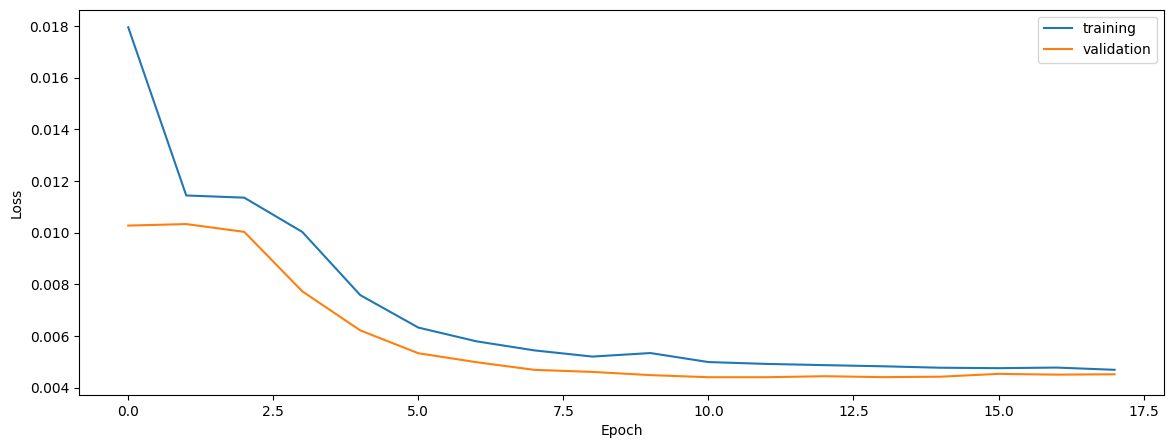

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

train
0.7566638513122766
0.7559575127053236
0.6464916329326158


In [8]:
print('normalized')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

normalized
0.7566638513122766
0.7559575127053236
0.6464916329326158


In [9]:
print('native')
print(getPearson(train[1][train[2]],train_pred[train[2]]))
print(getPearson(val[1][val[2]],val_pred[val[2]]))
print(getPearson(test[1][test[2]],test_pred[test[2]]))

native
0.7638978624841147
0.7721169000519971
0.6376881060618818


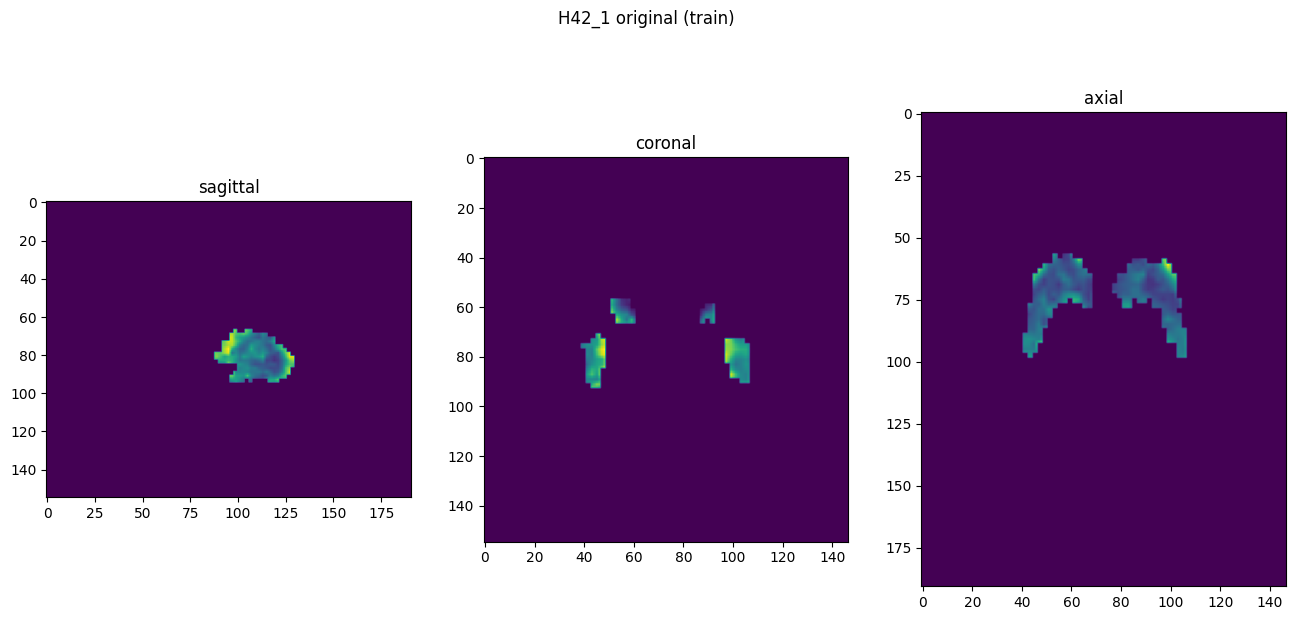

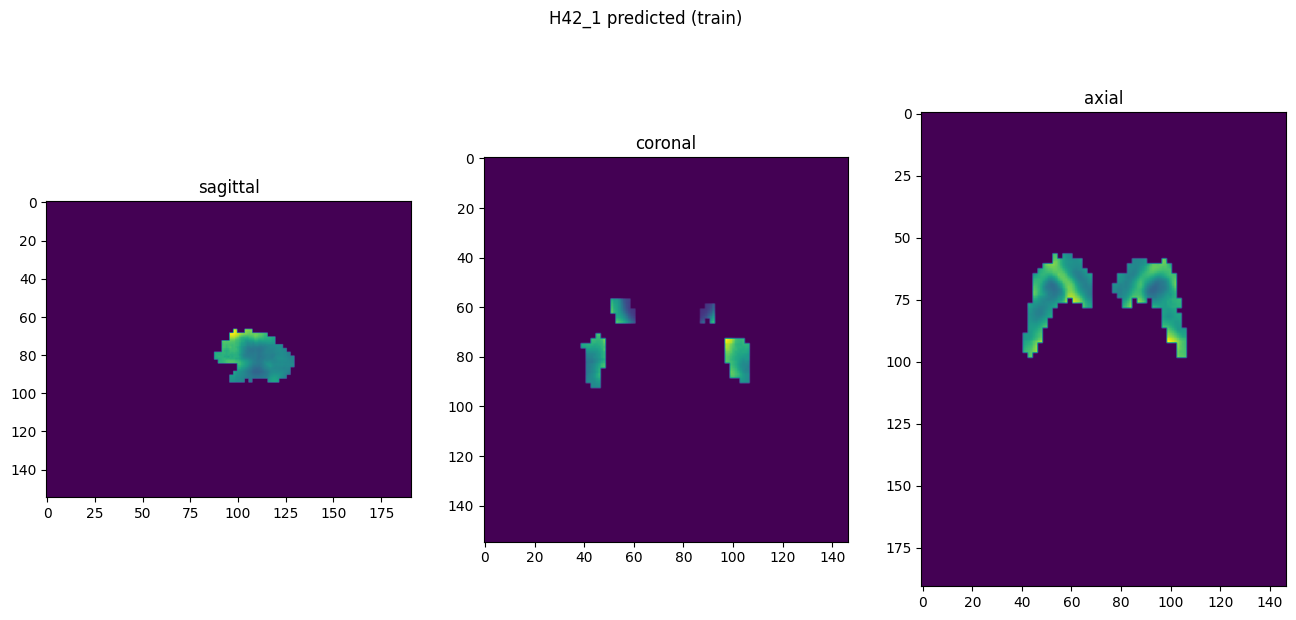

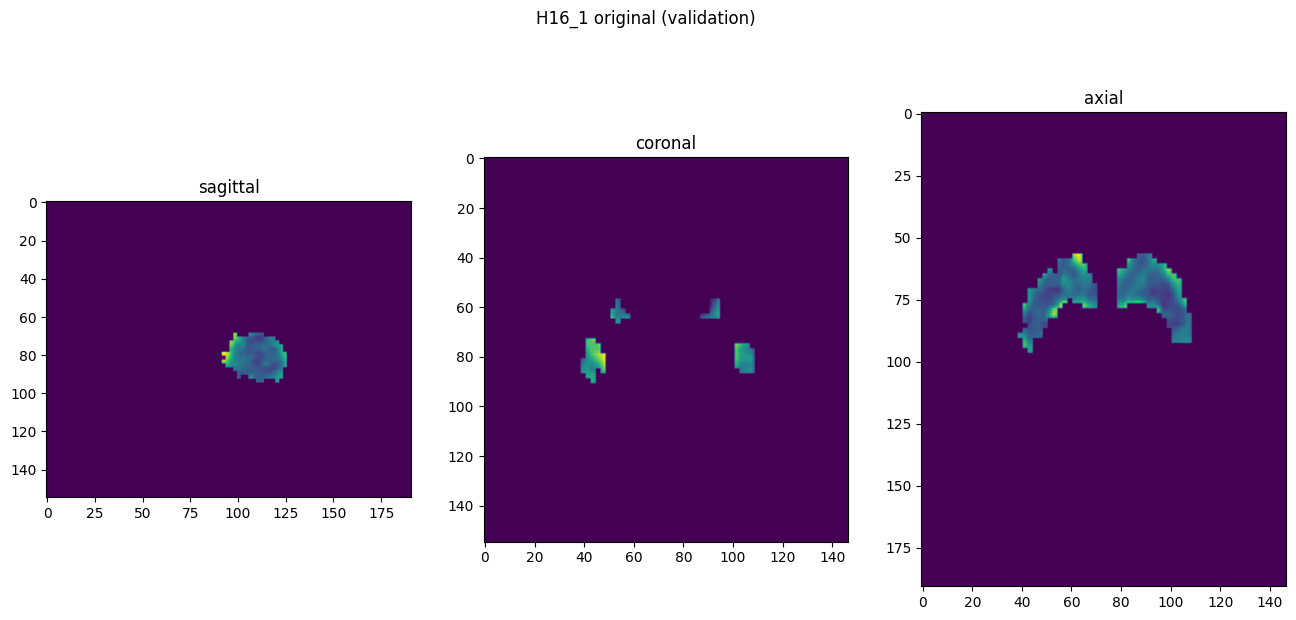

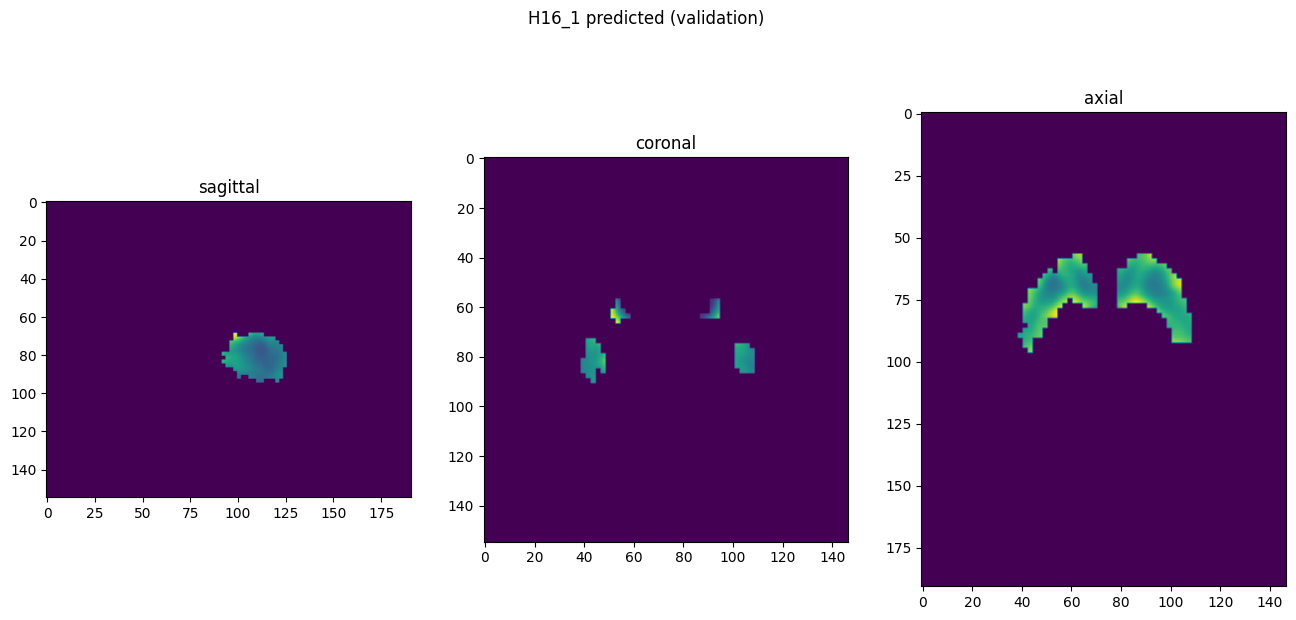

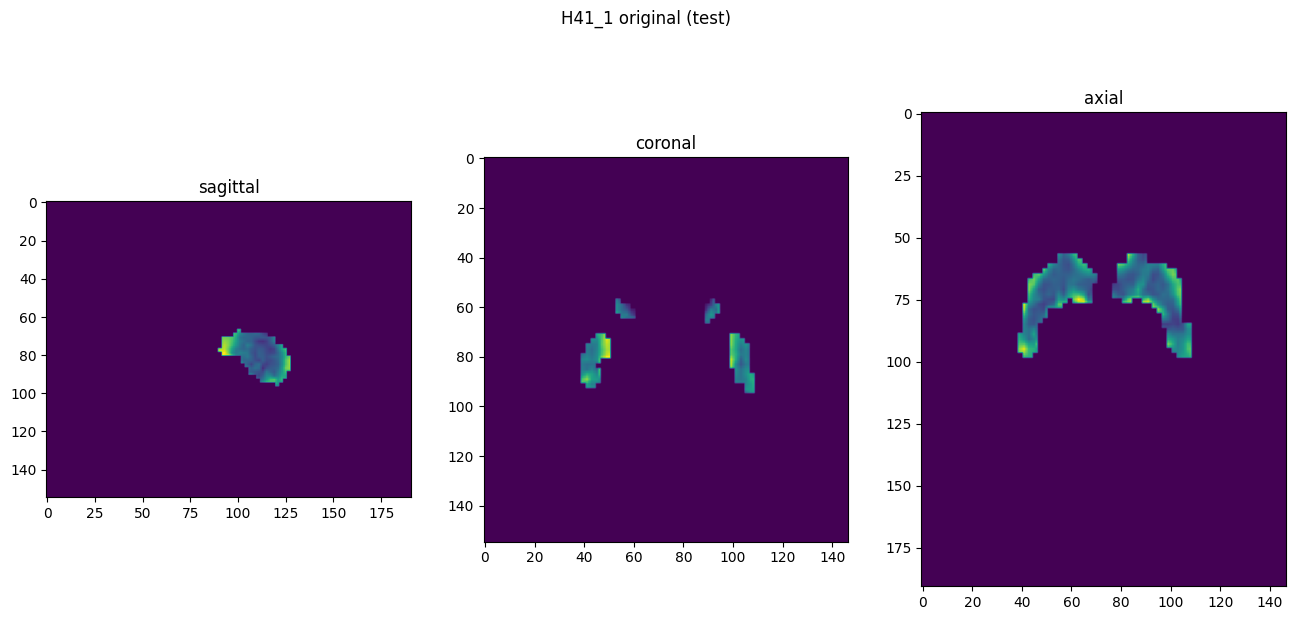

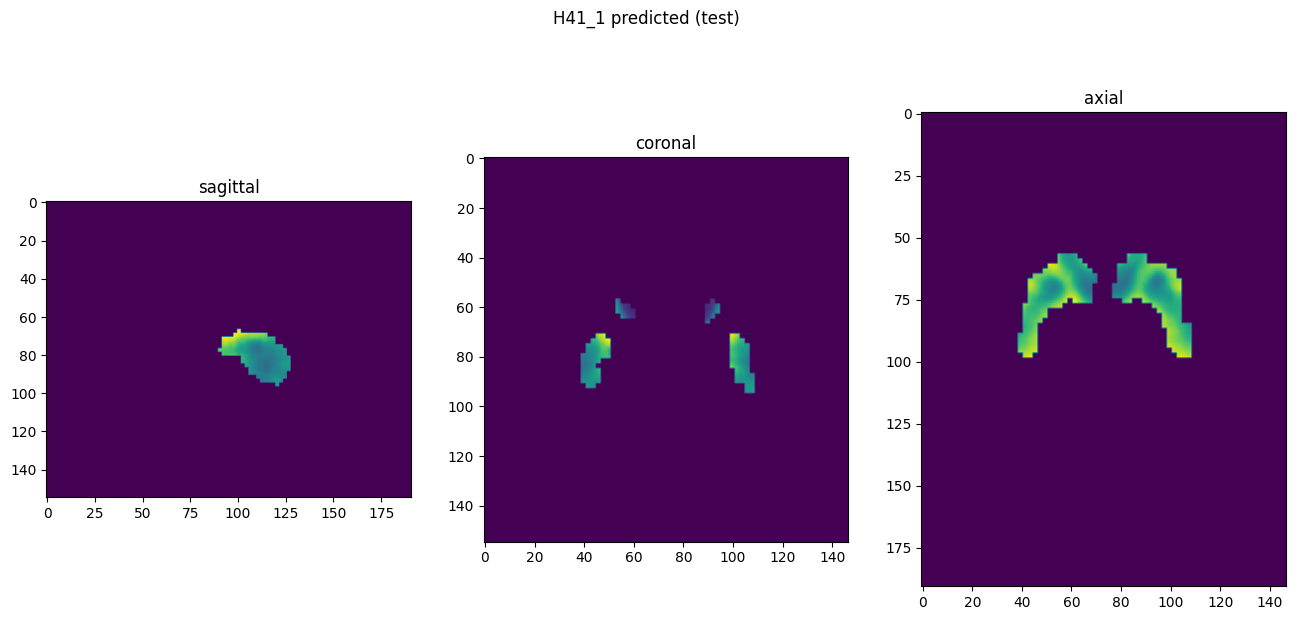

In [10]:
showResults(model, gen, threshold=None, background=False)